In [1]:
import numpy as np
import pandas as pd
import torch
#import lightning
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train_manual.csv')
test_data = pd.read_csv('test_manual.csv')

In [3]:
test_data.winddirection.fillna(test_data.winddirection.median(), inplace=True)

/tmp/ipykernel_1022350/2573330982.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data.winddirection.fillna(test_data.winddirection.median(), inplace=True)


In [4]:
features = [f for f in test_data if f not in ['id', 'Unnamed: 0']]

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(train_data[[c for c in train_data if c in features]], train_data['rainfall'], train_size=0.75, random_state=42)

In [6]:
device = 'cpu'

In [7]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(features), 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [8]:
class RainfallDataSet(Dataset):
    def __init__(self, X, y=None, train=False):
        self.X = tensor(X.values, dtype=torch.float32)
        self.train = train
        if train:
            self.y = tensor(y.values.reshape((-1, 1)), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.train:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [9]:
#train_loader = DataLoader(RainfallDataSet(X_train, train=True, y=y_train), batch_size=20, shuffle=True, num_workers=2)
train_loader = DataLoader(RainfallDataSet(train_data[features], train=True, y=train_data.rainfall), batch_size=50, shuffle=True, num_workers=6)

In [10]:
def cross_entropy_loss(labels, outputs):
    outputs = outputs.clip(1e-3, 1 - 1e-3)
    return -(labels * outputs.log() + (1 - labels) * (1 - outputs).log()).sum() / len(outputs)

In [14]:
losses = []
running_losses = []
val_losses = []
patience = 10000

net = NN()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        # Do the cross-entropy loss by hand, b/c the built-in function returns 0.
        loss = cross_entropy_loss(labels, outputs)

        loss.backward()
        optimizer.step()

        # log statistics:
        losses.append(loss.item())
        running_loss += loss.item()
        #if i % 100 == 0:
        #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.6f}')
        #    running_loss = 0.0

    running_losses.append(running_loss)

    # Calculate the test loss:
    with torch.no_grad():
        val_labels = tensor(y_validation.values.reshape((-1, 1)))
        y_val = net(tensor(X_validation.values, dtype=torch.float32))
        val_loss = cross_entropy_loss(val_labels, y_val)
        val_losses.append(val_loss)
    
    if epoch % 200 == 0:
        print(f'[{epoch + 1}] loss: {running_losses[-1]:.6f}, validation loss: {val_losses[-1]:.6f}')

    if min(val_losses) < min(val_losses[-patience:]):
        print(f'No improvement in the last {patience} epochs, stopping in epoch {epoch}.')
        break

print('Finished Training')

[1] loss: 8.455351, validation loss: 0.131980
[201] loss: 8.347110, validation loss: 0.141111
[401] loss: 7.931334, validation loss: 0.149893
[601] loss: 7.870708, validation loss: 0.139413
[801] loss: 7.613464, validation loss: 0.139214
[1001] loss: 8.332091, validation loss: 0.166163
[1201] loss: 7.892046, validation loss: 0.131796
[1401] loss: 8.210856, validation loss: 0.129957
[1601] loss: 7.555996, validation loss: 0.141412
[1801] loss: 8.105544, validation loss: 0.143031
[2001] loss: 8.319053, validation loss: 0.144816
[2201] loss: 8.399358, validation loss: 0.128934
[2401] loss: 7.658755, validation loss: 0.134028
[2601] loss: 7.182375, validation loss: 0.126379
[2801] loss: 7.446443, validation loss: 0.127295
[3001] loss: 7.988930, validation loss: 0.145360
[3201] loss: 7.825775, validation loss: 0.131037
[3401] loss: 8.002773, validation loss: 0.149468
[3601] loss: 7.975870, validation loss: 0.146035
[3801] loss: 7.964427, validation loss: 0.148984
[4001] loss: 7.800345, vali

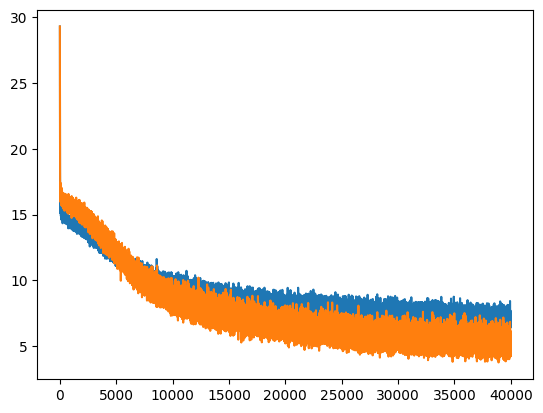

In [15]:
x = np.linspace(1, len(val_losses), len(val_losses), endpoint=True, dtype=int)
plt.plot(x, running_losses, x, np.asarray(val_losses) * max(running_losses) / max(val_losses))

In [16]:
with torch.no_grad():
    y_test = net(tensor(test_data[features].values, dtype=torch.float32))

pd.DataFrame(y_test, columns=['rainfall']).join(test_data.id).set_index('id', drop=True).to_csv('submission_torch.csv')